In [10]:
import pandas as pd 
import matplotlib.pyplot as plt
# import importlib.util
import pathlib
from statsmodels.imputation import mice
import estimator
import statsmodels.api as sm
from collections import defaultdict
import numpy as np


data= pd.read_csv('final5a.csv')


In [2]:
#This code block has been commented out but it was essentially importing the HW2 files. An alternative approach has been 
#used to import the HW2 files to allow for easier access via GitHub.

#We want to select only the columns that correspond to the variables I am interested in studying the causal relationship of

cols = ["classize", "towncode", "avgmath", "tipuach"]
data = data[cols]
print(data)

      classize  towncode  avgmath  tipuach
0           28   26104.0    74.11       24
1           26   26104.0    71.11       24
2           22   26104.0    64.00       38
3           15   26104.0    50.00       38
4           32    4622.0    68.38        6
...        ...       ...      ...      ...
2024        19   12682.0    68.47       26
2025        27   71001.0    70.27       22
2026        38    6957.0    70.10        0
2027        32    6957.0    69.53        0
2028        20    2469.0    50.37       60

[2029 rows x 4 columns]


In [3]:
#This shows the amount of missing data that currently exists in the original data files

data.isna().sum()

classize     0
towncode    51
avgmath      5
tipuach      0
dtype: int64

In [4]:
#This block was previously used as alternative for missing data. This was updated to instead use Mice as can be seen below.

# print(data["towncode"].mode())
# data["towncode"] = data["towncode"].fillna(30007.0)
# data["avgmath"] = data["avgmath"].fillna(data.avgmath.mean())
# data
# array_ = estimator.backdoor(df, confounders=["towncode", "tipuach"],intervention="classize", outcome="avgmath")
# print("length ", len(array_))
# print(array_)
# estimator.bootstrap(df, estimator.backdoor, n=100)

In [5]:
#Initializing a new dataframe 

df = pd.DataFrame(data)
df.dropna()
df

,classize,towncode,avgmath,tipuach
0,28,26104.0,74.11,24
1,26,26104.0,71.11,24
2,22,26104.0,64.00,38
3,15,26104.0,50.00,38
4,32,4622.0,68.38,6
...,...,...,...,...
2024,19,12682.0,68.47,26
2025,27,71001.0,70.27,22
2026,38,6957.0,70.10,0
2027,32,6957.0,69.53,0


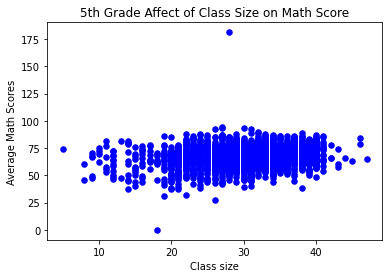

In [6]:
#This is irrelevant to the actual code and simply is there to see a graph of the classize and avgmath scores

df = pd.DataFrame(data)
df

x = df['classize']
y = df['avgmath']


plt.scatter(x, y, color= "blue",
            s=30)
plt.xlabel('Class size')
plt.ylabel('Average Math Scores')
plt.title("5th Grade Affect of Class Size on Math Score")
plt.show()

In [13]:
#Here we calculate backdoor estimator but we do with MICE so that we can account for missing data. The imp.next_sample() 
#generates new data(imputations) for missing data each time. Hence, we are doing this 10 times to take an average of 
#backdoor estimator on each of the generated samples to allow for more robust findings. The standard deviation is also 
#calculated as an extra means of evaluating the backdoor estimator results. Robust meaning less likely to have occurred by 
#chance and perhaps showing the actual relation between the presented variables. 

#Q2.3 but note this calls the backdoor function where the actual model definition is (please refer to estimator.py)
#New Code

main_df = df

imp2 = mice.MICEData(main_df) 
dict_estimators = defaultdict(list)
for j in range(10):
    df = imp2.next_sample()# generates datset with no missing data”
    array_ = estimator.backdoor(df, confounders=["towncode", "tipuach"],intervention="classize", outcome="avgmath")
#     print(len(array_))
    for array_estimate in range(len(array_)):
        dict_estimators[array_estimate].append(array_[array_estimate])
    
        
ret = []
stds= []
keys = sorted(dict_estimators.keys())
for key in keys:
    backdoor_estimates = dict_estimators[key]
    avg = np.mean(backdoor_estimates)
    std = np.std(backdoor_estimates)
    stds.append(std)
    ret.append(avg)

# ret = np.array(ret)
ret_str = [float("{:.3f}".format(r)) for r in ret]
print(f'Back Door Estimates: {ret_str}')


print(f'Standard Deviations: {stds}')

Back Door Estimates: [65.962, 66.379, 67.477, 67.74]
Standard Deviations: [0.0, 1.4210854715202004e-14, 0.0, 1.4210854715202004e-14]


In [12]:
#This is the place we actually run the estimator.bootstrap to see the uncertainty of the data. We have combined this wiht 
#mice here to allow for viewing the uncertainty that mice would provide as that is the method being used for 
#missing data. This has also bee repeated total of 100 times due to it being 10*10 to allow for more robust findings.
#New Code

def backdoor_mice(data, n_mice=10):
    imp = mice.MICEData(data)#datset with no missing data
    dict_mice = defaultdict(list)
    for j in range(n_mice):
        df = imp.next_sample()
        array_ = estimator.backdoor(df, confounders=["towncode", "tipuach"],intervention="classize", outcome="avgmath")
        for array_estimate in range(len(array_)):
            dict_mice[array_estimate].append(array_[array_estimate])
    ret = []
    keys = sorted(dict_mice.keys())#New Code
   
    for key in keys:
        backdoor_estimates = dict_mice[key]
        avg = np.mean(backdoor_estimates)
        ret.append(avg)
    return ret
# backdoor_mice(main_df)
estimator.bootstrap(main_df, backdoor_mice, n=10, n_mice=10) #n_mice*n = number of times backdoor mice runs


array([[65.02994557, 65.3347463 , 67.12236754, 64.70880551],
       [68.065814  , 66.91659719, 67.79937866, 69.2467382 ]])